In [179]:
import sys
sys.path.insert(0, '../../../../')
import numpy as np
import pandas as pd
import string
import os
#import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import mwc.viz
colors = mwc.viz.personal_style()
import mwc.fitderiv
import csv

# Define the experimental constants
STRAIN = 'delta'
CARBON = 'glucose'

In [189]:
DATE = 20190317
RUN_NO = 1
TEMP = 43
CARBON = 'glucose'
STRAIN = 'O2' #treat as operator if using mwc_growth strains

data = pd.read_csv(f'../../../../data/plate_reader/{DATE}_r{RUN_NO}_{TEMP}C_{CARBON}_{STRAIN}_growth.csv', skiprows=53)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xb0 in position 11: invalid start byte

In [2]:
gp_df = pd.read_csv(f'output/{STRAIN}_{CARBON}/per_well_output.csv')
stats_df = pd.read_csv(f'output/{STRAIN}_{CARBON}/per_well_stats.csv')


In [7]:
alpha_map = {alpha:no for alpha, no in zip(string.ascii_uppercase, np.arange(0, 27, 1) * 12)}
alphanumeric_map = {f'{a}{n}':alpha_map[a] + n for n in np.arange(1, 13, 1) for a in string.ascii_uppercase}
row_letters = {no:alpha for no, alpha in zip(np.arange(0, 27, 1),string.ascii_uppercase)}

In [43]:
data = gp_df[gp_df['well_id']==27].sort_values('time')
int(data[data['doubling_time'] == data['doubling_time'].min()]['time'])

916

Text(0.5,1,'doubling time vs time')

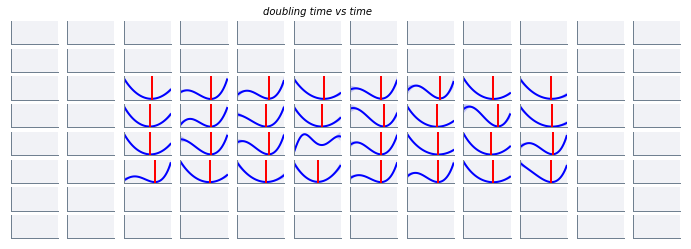

In [44]:
## Plot doubling time curves for all wells
fig, ax = plt.subplots(8,12, figsize=(12, 4))

for r in np.arange(0,8,1):
    for c in np.arange(0,12,1):
        well_id = alphanumeric_map[f'{row_letters[r]}{c+1}']
        data = gp_df[gp_df['well_id']==well_id].sort_values('time')
        ax[r][c].get_xaxis().set_visible(False)
        ax[r][c].get_yaxis().set_visible(False)
        if not data.empty:
            ax[r][c].plot(data['time'],data['doubling_time'],c='b')
            ax[r][c].fill_between(data['time'], data['doubling_time']-data['doubling_time_std'], 
                                  data['doubling_time']+data['doubling_time_std'],
                                  facecolor= 'blue', alpha= 0.2)
            ax[r][c].axvline(x=int(data[data['doubling_time'] == data['doubling_time'].min()]['time']),c='red')
ax[0][5].set_title('doubling time vs time', fontsize = 10)
#plt.savefig(f'output/{STRAIN}_{CARBON}/gp_curves_{well}.png')

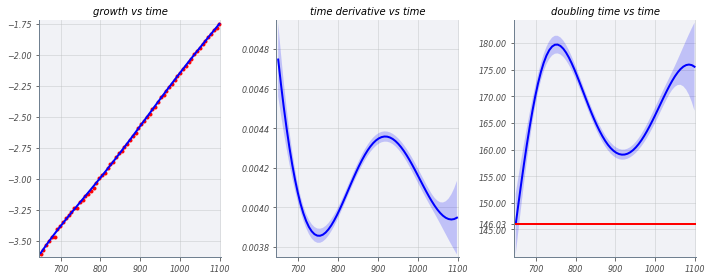

In [135]:
data = gp_df[gp_df['well_id']==54].sort_values('time')
fig, ax = plt.subplots(ncols = 3, figsize=(10, 4))
ax[0].set_title('growth vs time', fontsize = 10)
ax[1].set_title('time derivative vs time', fontsize = 10)
ax[2].set_title('doubling time vs time', fontsize = 10)

ax[0].scatter(data['time'],np.log(data['OD_raw_data']),c='r', marker = '.')
ax[0].plot(data['time'],data['log(OD)_fit'],c='blue')
ax[0].fill_between(data['time'], data['log(OD)_fit']-data['log(OD)_fit_std'], 
                      data['log(OD)_fit']+data['log(OD)_fit_std'],
                      facecolor= 'blue', alpha= 0.2)

ax[1].plot(data['time'],data['growth_rate'],c='b')
ax[1].fill_between(data['time'], data['growth_rate']-data['growth_rate_std'], 
                      data['growth_rate']+data['growth_rate_std'],
                      facecolor= 'blue', alpha= 0.2)

ax[2].plot(data['time'],data['doubling_time'],c='b')
ax[2].fill_between(data['time'], data['doubling_time']-data['doubling_time_std'], 
                      data['doubling_time']+data['doubling_time_std'],
                      facecolor= 'blue', alpha= 0.2)
ax[2].axhline(y=data.min()['doubling_time'],c='red')
locs = ax[2].get_yticks()
plt.yticks(np.append(locs[2:-1],round(data.min()['doubling_time'],2)))

plt.tight_layout()

In [71]:
_temp = stats_df[stats_df['well_id']==27]

In [74]:
_temp[_temp['parameter'] == 'inverse max df']

,parameter,value,well_id,carbon,strain
8,inverse max df,166.675213,27,glucose,delta


In [66]:
_test = stats_df[stats_df['parameter'] == 'inverse max df']
_test[_test['well_id']==29]

,parameter,value,well_id,carbon,strain
44,inverse max df,159.767175,29,glucose,delta


In [77]:
plate = np.zeros((8, 12),dtype = int)
for r in np.arange(0,8,1):
    for c in np.arange(0,12,1):
        well_id = alphanumeric_map[f'{row_letters[r]}{c+1}']
        _temp = stats_df[stats_df['well_id']==well_id]
        if not _temp.empty:
            plate[r][c] = int(_temp[_temp['parameter'] == 'inverse max df']['value'])
plate

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0, 166, 158, 159, 160, 159, 160, 164, 165,   0,   0],
       [  0,   0, 161, 157, 156, 159, 162, 160, 163, 162,   0,   0],
       [  0,   0, 163, 165, 163, 146, 159, 162, 160, 158,   0,   0],
       [  0,   0, 159, 162, 162, 159, 157, 159, 162, 160,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])

Text(0.5,1,'doubling times')

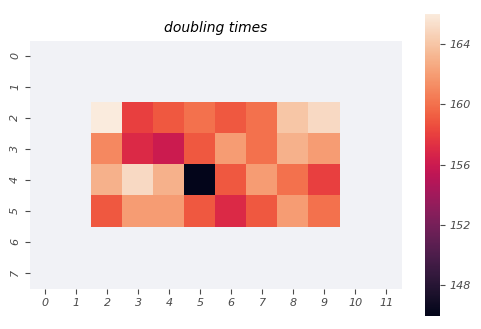

In [170]:
## Plot heatmap of minimum doubling times for all wells
import seaborn as sns

plate = np.full((8, 12),np.nan)
for r in np.arange(0,8,1):
    for c in np.arange(0,12,1):
        well_id = alphanumeric_map[f'{row_letters[r]}{c+1}']
        _temp = stats_df[stats_df['well_id']==well_id]
        if not _temp.empty:
            plate[r][c] = int(_temp[_temp['parameter'] == 'inverse max df']['value'])
mask = np.isnan(plate)
ax = sns.heatmap(plate, mask=mask, square = True)
ax.set_title('doubling times', fontsize = 10)
#plt.savefig(f'output/{STRAIN}_{CARBON}/gp_curves_{well}.png')

Text(0.5,1,'20190228_r1_32C_glucose_O2 doubling times')

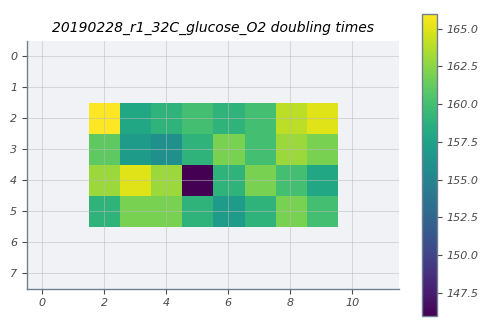

In [178]:
fig, ax = plt.subplots()
plate = np.full((8, 12),np.nan)
for r in np.arange(0,8,1):
    for c in np.arange(0,12,1):
        well_id = alphanumeric_map[f'{row_letters[r]}{c+1}']
        _temp = stats_df[stats_df['well_id']==well_id]
        if not _temp.empty:
            plate[r][c] = int(_temp[_temp['parameter'] == 'inverse max df']['value'])
mask = np.isnan(plate)
im = ax.imshow(plate) #cmap=plt.cm.hot, interpolation='none', , vmin=70
cbar = fig.colorbar(im)#, extend='min'
#cbar.cmap.set_under('purple')

#    ax = sns.heatmap(plate, mask=mask, square = True)
ax.set_title(f'{DATE}_r{RUN_NO}_{TEMP}C_{CARBON}_{STRAIN} doubling times', fontsize = 10)
#plt.savefig(f'output/{STRAIN}_{CARBON}/per_well_doubling_times_heatmap.png')    
#plt.close()

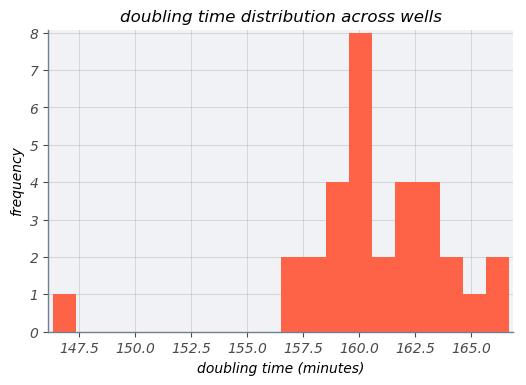

In [155]:
fig, ax = plt.subplots()
ax.hist(stats_df[stats_df['parameter']=='inverse max df']['value'], bins = 20, color= 'tomato')
ax.set_xlabel('doubling time (minutes)', fontsize = 10)
ax.set_ylabel('frequency', fontsize = 10)
ax.set_title('doubling time distribution across wells', fontsize = 12)
ax.tick_params(labelsize=10)

In [154]:
import statsmodels.api as sm # recommended import according to the docs


/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


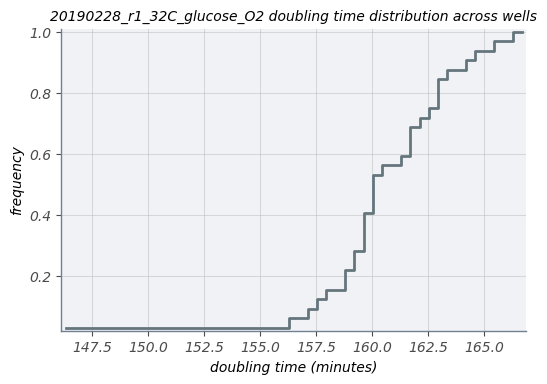

In [160]:
fig, ax = plt.subplots()
dat = stats_df[stats_df['parameter']=='inverse max df']['value']
ecdf = sm.distributions.ECDF(dat)
x = np.linspace(min(dat), max(dat))
y = ecdf(x)
ax.step(x, y)
ax.set_xlabel('doubling time (minutes)', fontsize = 10)
ax.set_ylabel('frequency', fontsize = 10)
ax.set_title(f'{DATE}_r{RUN_NO}_{TEMP}C_{CARBON}_{STRAIN} doubling time distribution across wells', fontsize = 10)
ax.tick_params(labelsize=10)


In [152]:
# import sys
# sys.path.insert(0, '../../../../')
# import numpy as np
# import pandas as pd
# import string
# import os
# import csv
# import matplotlib
# matplotlib.use('Agg')
# import matplotlib.pyplot as plt
# import mwc.viz
# colors = mwc.viz.personal_style()

# Define the experimental constants
DATE = 20190228
RUN_NO = 1
TEMP = 32
CARBON = 'glucose'
STRAIN = 'O2' #treat as operator if using mwc_growth strains

# Create translation maps
alpha_map = {alpha:no for alpha, no in zip(string.ascii_uppercase, np.arange(0, 27, 1) * 12)}
alphanumeric_map = {f'{a}{n}':alpha_map[a] + n for n in np.arange(1, 13, 1) for a in string.ascii_uppercase}

# Assign strains and carbons to wells that weren't blanks
strain_wells = {**{alphanumeric_map[f'{row}{col}']:'delta' 
                   for row in ['C','D','E','F'] for col in np.arange(3, 10+1, 1)}}
carbon_wells = {**{alphanumeric_map[f'{row}{col}']:'glucose' 
                   for row in ['C','D','E','F'] for col in np.arange(3, 10+1, 1)}}

# ----------------------------------

# Load the data. 
data = pd.read_csv(f'../../../../data/plate_reader/{DATE}_r{RUN_NO}_{TEMP}C_{CARBON}_{STRAIN}_growth.csv', skiprows=53)

In [153]:
data

,Time,T Read 2:600,A1,A2,A3,A4,A5,A6,A7,A8,...,H3,H4,H5,H6,H7,H8,H9,H10,H11,H12
0,0:06:10,32.1,0.078,0.079,0.077,0.078,0.077,0.077,0.078,0.076,...,0.076,0.076,0.076,0.077,0.077,0.078,0.078,0.079,0.078,0.078
1,0:13:10,32.0,0.078,0.079,0.077,0.078,0.076,0.077,0.078,0.076,...,0.076,0.076,0.076,0.076,0.076,0.078,0.078,0.078,0.078,0.078
2,0:20:10,32.0,0.078,0.079,0.077,0.078,0.077,0.076,0.078,0.076,...,0.076,0.076,0.076,0.076,0.077,0.078,0.078,0.079,0.078,0.078
3,0:27:10,32.0,0.078,0.079,0.077,0.078,0.077,0.077,0.078,0.076,...,0.076,0.076,0.076,0.076,0.077,0.078,0.078,0.079,0.078,0.078
4,0:34:10,32.1,0.078,0.079,0.077,0.078,0.076,0.076,0.078,0.076,...,0.076,0.076,0.076,0.076,0.077,0.078,0.078,0.079,0.078,0.078
5,0:41:10,32.0,0.078,0.079,0.077,0.078,0.076,0.076,0.078,0.076,...,0.076,0.076,0.076,0.076,0.076,0.078,0.078,0.079,0.078,0.078
6,0:48:10,32.0,0.078,0.079,0.077,0.078,0.076,0.076,0.078,0.076,...,0.076,0.076,0.076,0.076,0.076,0.078,0.078,0.079,0.078,0.078
7,0:55:10,32.0,0.078,0.079,0.077,0.079,0.077,0.076,0.078,0.076,...,0.076,0.076,0.075,0.076,0.077,0.078,0.078,0.078,0.078,0.078
8,1:02:10,32.0,0.078,0.079,0.077,0.079,0.077,0.076,0.078,0.076,...,0.076,0.076,0.075,0.076,0.077,0.078,0.078,0.079,0.078,0.078
9,1:09:10,32.1,0.078,0.079,0.077,0.079,0.077,0.076,0.078,0.076,...,0.076,0.076,0.076,0.076,0.076,0.078,0.078,0.079,0.078,0.078
